In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from astropy.table import Table
import astropy.units as u
import astropy.constants as c

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

from scipy import interpolate
from scipy import stats
#from sklearn import svm

#Suppressing astropy units warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppressing Pandas chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'


import seaborn as sns
#berry = ['#6797aa', '#7d3f79', '#201e5b', '#dda3d1', '#805da4', '#0c0c0d']
#sns.set_palette(sns.color_palette(berry))
#sns.palplot(sns.color_palette(berry))
#sns.palplot(sns.color_palette("cubehelix", 10))

sns.set(style="ticks", 
        context="paper",
        font_scale=1,
        palette=sns.color_palette("coolwarm"))

sc_kws = {"cmap": "viridis", 
          "s": 10, 
          "rasterized":True, 
          "lw": 0.25, 
          "alpha": 1}

In [2]:
df = pd.read_parquet('../data/data.parquet')
df.head()
print(np.shape(df))

(9750, 1371)


In [3]:
df = df.drop_duplicates(subset=['kepid'], keep='first')
print(np.shape(df))

(8214, 1371)


In [4]:
df = df[df['bf18_[Fe/H]'].notna()]
print(np.shape(df))

df = df[df['cks_age'].notna()]
print(np.shape(df))

df = df[df['bf18_[Y/Al]'].notna()]
print(np.shape(df))

df = df[df['bf18_[Y/Mg]'].notna()]
print(np.shape(df))

df = df[df['p20_cks_steff'].notna()]
print(np.shape(df))

#df = df[df['cks_age'].notna()]
#print(np.shape(df))

(1059, 1371)
(934, 1371)
(934, 1371)
(934, 1371)
(926, 1371)


In [5]:
from sklearn.linear_model import LinearRegression


def hrd_compare(source='cks',
               fig_path=None):
    sns.set(style="ticks", context="paper")
    colors = sns.color_palette("viridis", 4)
 
    if source=='cks':
        teff = df['p20_cks_steff']
        teff_err = np.max([df['p20_cks_steff_err1'],df['p20_cks_steff_err2']],axis=0)
        logg = df['p20_cks_slogg']
        logg_err = np.max([df['p20_cks_slogg_err1'],df['p20_cks_slogg_err2']],axis=0)
        feh  = df['p20_cks_smet']
        feh_err  = np.max([df['p20_cks_smet_err1'],df['p20_cks_smet_err2']],axis=0)
        age  = df['cks_age']
        age_lerr  = df['cks_e_age']
        age_uerr  = df['cks_E_age']
        tex_column = 'CKS-Gaia'

    elif source=='spocs':
        teff = df['bf18_Teff']
        teff_err = df['bf18_e_Teff']
        logg = df['bf18_log(g)']
        logg_err = df['bf18_e_log(g)']
        feh = df['bf18_[Fe/H]']
        feh_err = df['bf18_e_[Fe/H]']
        age  = df['bf18_Age']
        age_lerr  = df['bf18_e_Age']
        age_uerr  = df['bf18_E_Age']
        tex_column = 'SPOCS'
        
    elif source=='berger':
        teff = df['b20_iso_teff']
        teff_err = np.max([-df['b20_iso_teff_err2'], df['b20_iso_teff_err1']],axis=0)
        logg = df['b20_iso_logg']
        logg_err = np.max([-df['b20_iso_logg_err2'], df['b20_iso_logg_err1']],axis=0)
        feh = df['b20_iso_feh']
        feh_err = np.max([-df['b20_iso_feh_err2'], df['b20_iso_feh_err1']],axis=0)
        age  = df['b20_iso_age']
        age_lerr  = -df['b20_iso_age_err2']
        age_uerr  = df['b20_iso_age_err1']
        tex_column = 'GKSPC'
        
    
    yal  = df['bf18_[Y/Al]']
    yal_err  = df['bf18_e_[Y/Al]']
    ymg  = df['bf18_[Y/Mg]']
    ymg_err = df['bf18_e_[Y/Mg]']
    
    group1 = (logg<4.1)
    group2 = (logg>=4.1) & (teff>=5500)
    group3 = (logg>=4.2) & (teff<5500)
    group4 = (teff>5600)&(teff<5950)&\
             (logg>4.2)&(logg<4.53)&\
             (feh>-0.3)&(feh<0.3)# & (df['bf18_S/N']>30)
    

    group_labels = ['Evolved stars', 'Hot dwarfs', 'Cool dwarfs', 'Solar twins']

    sc_kws = {"s":3, "rasterized":True}

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(8,6))

    for i,group in enumerate([group1,group2,group3,group4]):

        ax[0][i].set_title(group_labels[i])
        ax[0][i].scatter(teff, logg, color='lightgrey', **sc_kws)
        ax[0][i].scatter(teff[group], logg[group], **sc_kws, color=colors[0])
        ax[0][i].invert_xaxis()
        ax[0][i].invert_yaxis()
        ax[0][i].set_xlabel("Teff [K]"); ax[0][i].set_ylabel("log(g) [dex]")
        ax[0][i].errorbar(7000,4.8,
                          xerr=np.nanmedian(teff_err[group]),
                          yerr=np.nanmedian(logg_err[group]), fmt='.', color='k')

        ax[1][i].scatter(age, ymg, color='lightgrey', **sc_kws)
        ax[1][i].scatter(age[group], ymg[group], **sc_kws, color=colors[0])
        ax[1][i].errorbar(2.5,-0.75,
                          xerr=np.nanmedian(df['cks_age_maxerr'][group]), 
                          yerr=np.nanmedian(ymg_err[group]), fmt='.', color='k')


        _ = group & (np.isfinite(age)) & (np.isfinite(ymg)) & (np.isfinite(yal))


        medslope, medintercept, lo_slope, hi_slope = stats.theilslopes(ymg[_], age[_], 0.90)
        resid = (medintercept+medslope*age[_] - ymg[_])
        rms = np.sqrt(np.median(resid ** 2))
        
        
        #fit regression model
        model = LinearRegression()
        X, y = ymg[group].values.reshape(-1,1), age[group]
        model.fit(X, y)

        #display adjusted R-squared
        adj_rsq = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)        
        
        
        print(tex_column, " & [Y/Mg] & ", group_labels[i],"&",
              "{:.4f}".format(medintercept),"&", 
              "{:.4f}".format(medslope),"$_{-",
              "{:.4f}".format(medslope-lo_slope),"}^{+",
              "{:.4f}".format(hi_slope-medslope),"}$ &",
              "{:.3f}".format(rms)+" & "+
              "{:.3f}".format(adj_rsq)+"\\\\")

        ax[1][i].plot(age, medintercept+age*medslope, color=colors[3])
        ax[1][i].set_ylim(-1,1)
        ax[1][i].set_xlabel("Age [Gyr]"); ax[1][i].set_ylabel("[Y/Mg]")


        ax[2][i].scatter(age, yal, color='lightgrey', **sc_kws)
        ax[2][i].scatter(age[group], yal[group], **sc_kws, color=colors[0]) 
        ax[2][i].errorbar(2.5,-0.75,
                          xerr=np.nanmedian(df['cks_age_maxerr'][group]), 
                          yerr=np.nanmedian(yal_err[group]), fmt='.', color='k')    
        ax[2][i].set_xlabel("Age [Gyr]"); ax[2][i].set_ylabel("[Y/Al]")

        medslope, medintercept, lo_slope, hi_slope = stats.theilslopes(yal[_], age[_], 0.90)
        resid = (medintercept+medslope*age[_] - ymg[_])
        rms = np.sqrt(np.median(resid ** 2))     
        
        
        #fit regression model
        model = LinearRegression()
        X, y = yal[group].values.reshape(-1,1), age[group]
        model.fit(X, y)

        #display adjusted R-squared
        adj_rsq = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)                
        
        
        print(tex_column, " & [Y/Al] & ", group_labels[i],"&",
              "{:.4f}".format(medintercept),"&", 
              "{:.4f}".format(medslope),"$_{-",
              "{:.4f}".format(medslope-lo_slope),"}^{+",
              "{:.4f}".format(hi_slope-medslope),"}$ &",
              "{:.3f}".format(rms)+" & "+
              "{:.3f}".format(adj_rsq)+"\\\\")    
        
        ax[2][i].plot(age, medintercept+age*medslope, color=colors[3])
        ax[2][i].set_ylim(-1,1)    


    plt.tight_layout()
    if fig_path:
        plt.savefig(fig_path)
    plt.show()

CKS-Gaia  & [Y/Mg] &  Evolved stars & 0.2566 & -0.0369 $_{- 0.0046 }^{+ 0.0043 }$ & 0.064 & 0.378\\
CKS-Gaia  & [Y/Al] &  Evolved stars & 0.2834 & -0.0467 $_{- 0.0065 }^{+ 0.0065 }$ & 0.082 & 0.297\\
CKS-Gaia  & [Y/Mg] &  Hot dwarfs & 0.1100 & -0.0201 $_{- 0.0018 }^{+ 0.0019 }$ & 0.055 & 0.323\\
CKS-Gaia  & [Y/Al] &  Hot dwarfs & 0.1659 & -0.0260 $_{- 0.0027 }^{+ 0.0028 }$ & 0.055 & 0.253\\
CKS-Gaia  & [Y/Mg] &  Cool dwarfs & 0.0032 & -0.0150 $_{- 0.0055 }^{+ 0.0053 }$ & 0.091 & 0.083\\
CKS-Gaia  & [Y/Al] &  Cool dwarfs & -0.0391 & -0.0142 $_{- 0.0058 }^{+ 0.0057 }$ & 0.094 & 0.073\\
CKS-Gaia  & [Y/Mg] &  Solar twins & 0.0914 & -0.0168 $_{- 0.0031 }^{+ 0.0028 }$ & 0.044 & 0.302\\
CKS-Gaia  & [Y/Al] &  Solar twins & 0.1093 & -0.0215 $_{- 0.0036 }^{+ 0.0031 }$ & 0.048 & 0.364\\


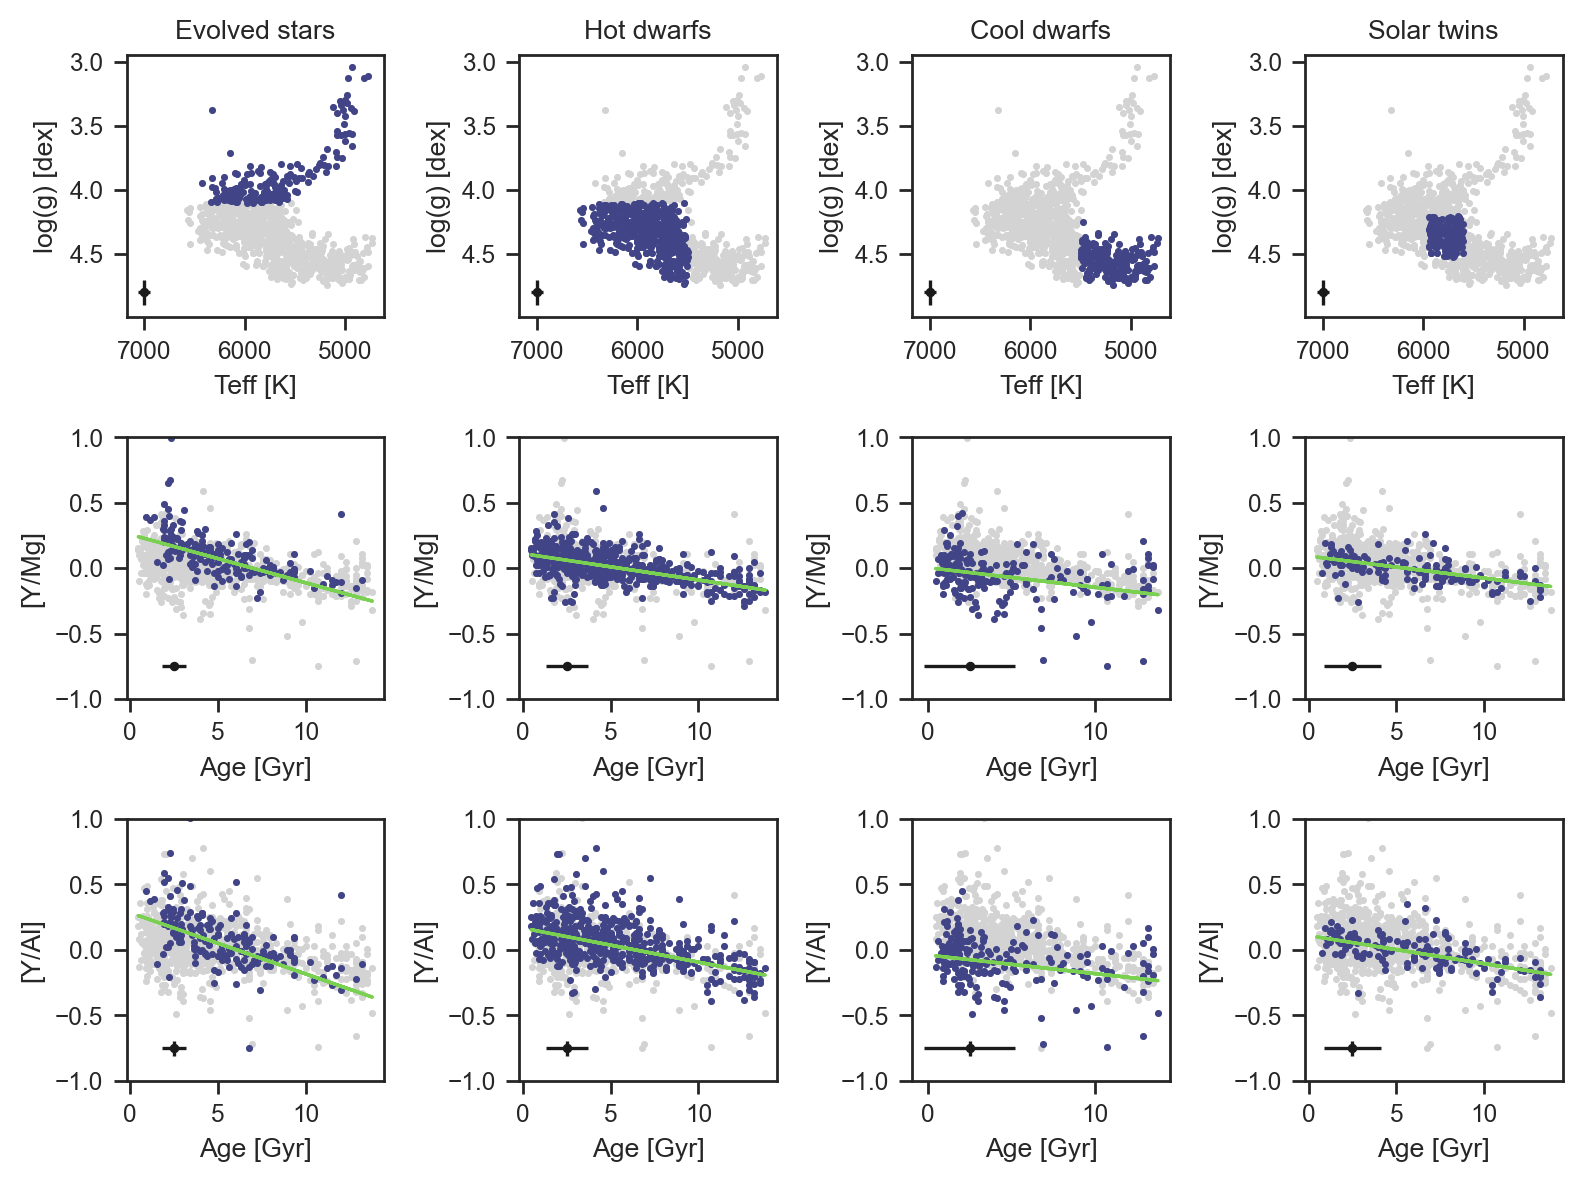

In [8]:
hrd_compare(source='cks', fig_path='../figures/hrdcompare-cks.pdf')

SPOCS  & [Y/Mg] &  Evolved stars & 0.2542 & -0.0367 $_{- 0.0064 }^{+ 0.0067 }$ & 0.065 & 0.237\\
SPOCS  & [Y/Al] &  Evolved stars & 0.3591 & -0.0593 $_{- 0.0094 }^{+ 0.0091 }$ & 0.083 & 0.276\\
SPOCS  & [Y/Mg] &  Hot dwarfs & 0.1265 & -0.0229 $_{- 0.0028 }^{+ 0.0030 }$ & 0.058 & 0.208\\
SPOCS  & [Y/Al] &  Hot dwarfs & 0.2376 & -0.0375 $_{- 0.0041 }^{+ 0.0040 }$ & 0.063 & 0.254\\
SPOCS  & [Y/Mg] &  Cool dwarfs & 0.2068 & -0.0237 $_{- 0.0048 }^{+ 0.0046 }$ & 0.083 & 0.241\\
SPOCS  & [Y/Al] &  Cool dwarfs & 0.2298 & -0.0280 $_{- 0.0055 }^{+ 0.0052 }$ & 0.080 & 0.266\\
SPOCS  & [Y/Mg] &  Solar twins & 0.1635 & -0.0294 $_{- 0.0058 }^{+ 0.0055 }$ & 0.044 & 0.301\\
SPOCS  & [Y/Al] &  Solar twins & 0.2311 & -0.0397 $_{- 0.0069 }^{+ 0.0073 }$ & 0.054 & 0.309\\


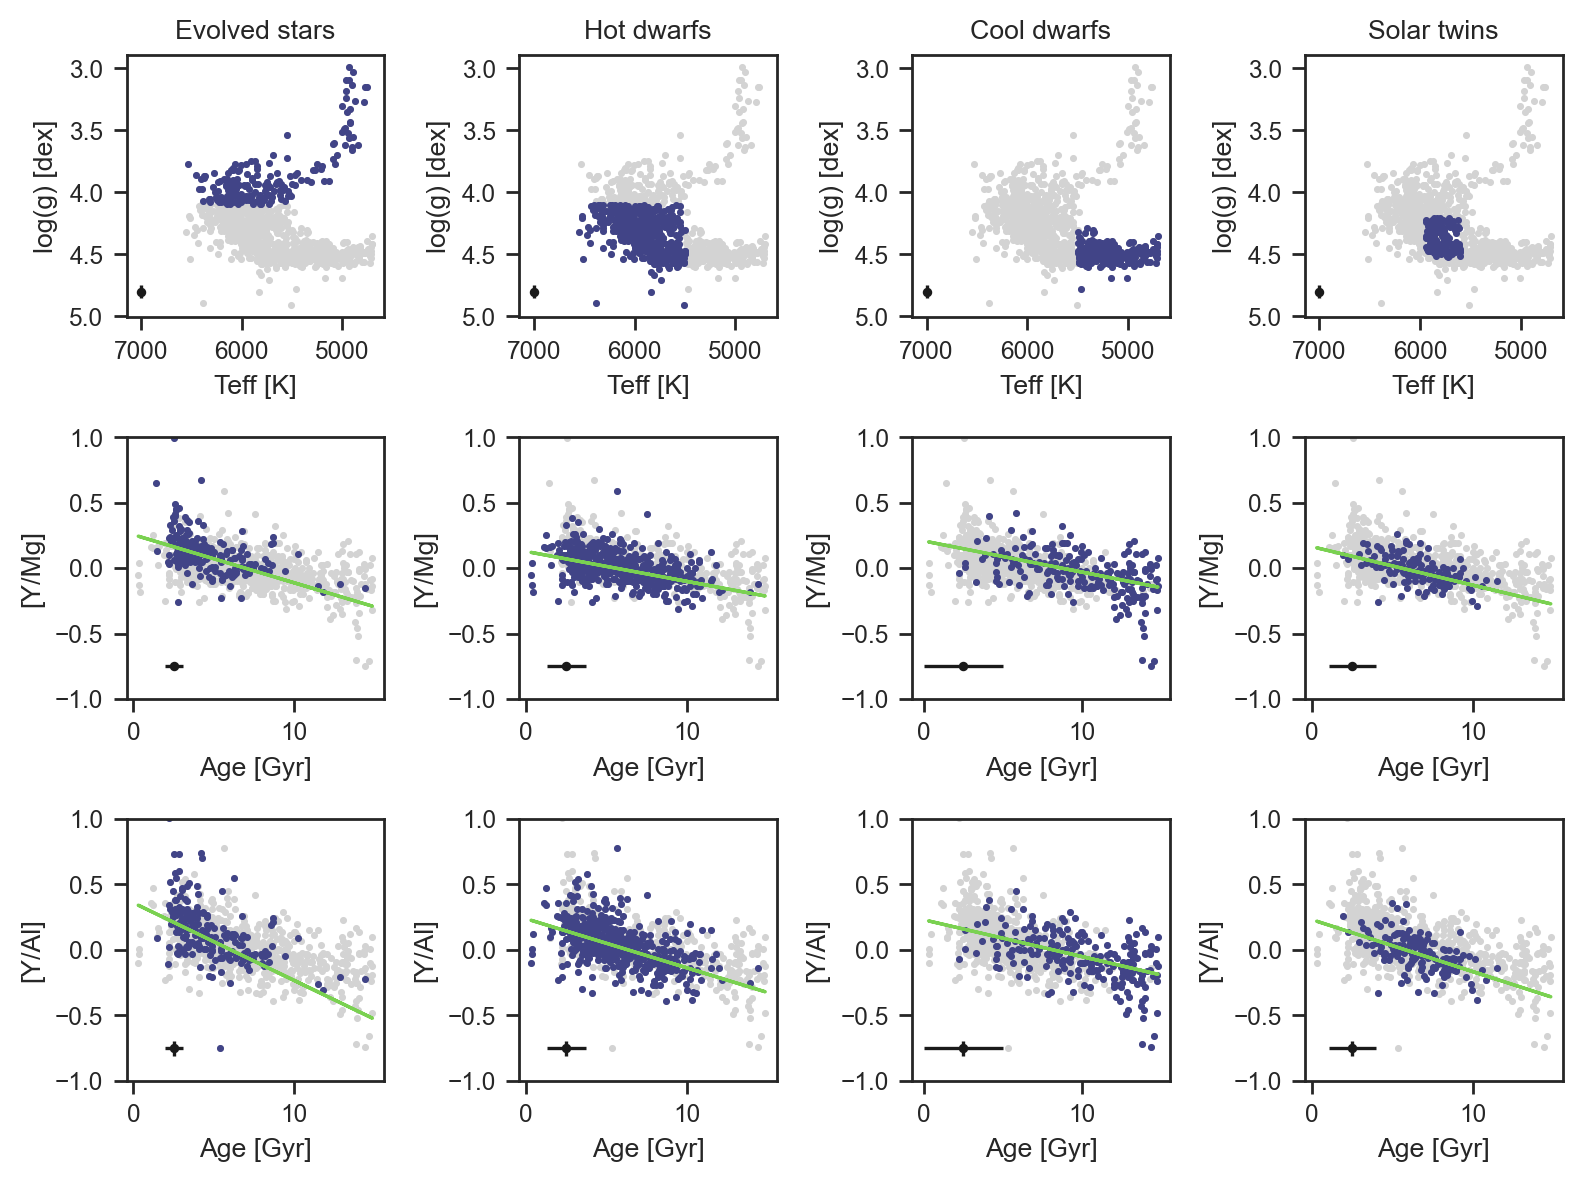

In [7]:
#hrd_compare(source='spocs', fig_path='./figures/hrdcompare-spocs.pdf')
hrd_compare(source='spocs')

GKSPC  & [Y/Mg] &  Evolved stars & 0.2370 & -0.0394 $_{- 0.0061 }^{+ 0.0060 }$ & 0.065 & 0.247\\
GKSPC  & [Y/Al] &  Evolved stars & 0.2966 & -0.0536 $_{- 0.0079 }^{+ 0.0088 }$ & 0.082 & 0.266\\
GKSPC  & [Y/Mg] &  Hot dwarfs & 0.0626 & -0.0203 $_{- 0.0034 }^{+ 0.0034 }$ & 0.065 & 0.160\\
GKSPC  & [Y/Al] &  Hot dwarfs & 0.1359 & -0.0343 $_{- 0.0048 }^{+ 0.0046 }$ & 0.069 & 0.192\\
GKSPC  & [Y/Mg] &  Cool dwarfs & 0.0789 & -0.0196 $_{- 0.0070 }^{+ 0.0066 }$ & 0.093 & 0.071\\
GKSPC  & [Y/Al] &  Cool dwarfs & 0.0958 & -0.0226 $_{- 0.0086 }^{+ 0.0082 }$ & 0.092 & 0.072\\
GKSPC  & [Y/Mg] &  Solar twins & 0.0445 & -0.0184 $_{- 0.0067 }^{+ 0.0065 }$ & 0.070 & 0.165\\
GKSPC  & [Y/Al] &  Solar twins & 0.0759 & -0.0261 $_{- 0.0079 }^{+ 0.0080 }$ & 0.077 & 0.182\\


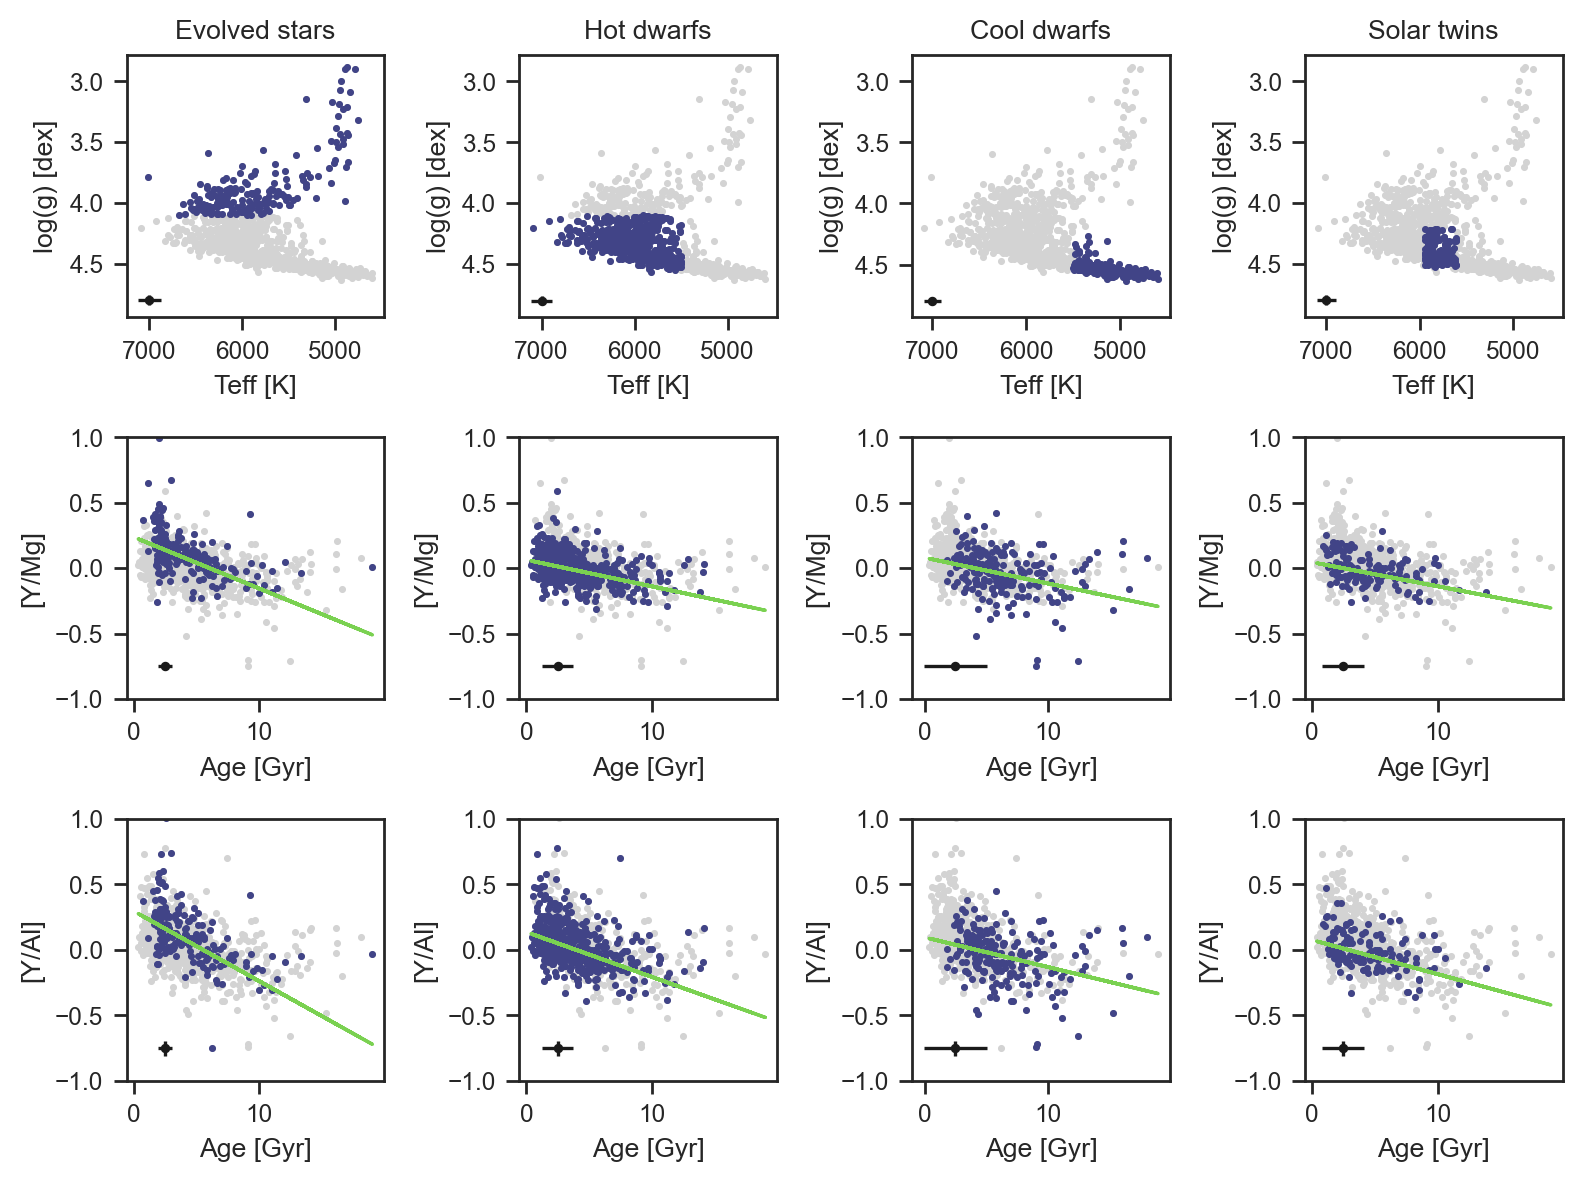

In [10]:
hrd_compare(source='berger', fig_path='../figures/hrdcompare-gkspc.pdf')

In [12]:
nis_t1 = Table.read("http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/table1.dat",
                readme="http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/ReadMe",
                format="ascii.cds")

nis_t2 = Table.read("http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/table2.dat",
                readme="http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/ReadMe",
                format="ascii.cds")

nis = join(nis_t1,nis_t2)

nis['ymg_ratio'] = nis['[Y/Fe]'] - nis['[Mg/Fe]']
nis['yal_ratio'] = nis['[Y/Fe]'] - nis['[Al/Fe]']


n20_sun_like = (df['bf18_Teff']>5600)&(df['bf18_Teff']<5950)&\
               (df['bf18_log(g)']>4.2)&(df['bf18_log(g)']<4.53)&\
               (df['bf18_[Fe/H]']>-0.3)&(df['bf18_[Fe/H]']<0.3) #& (df['bf18_S/N']>30)


nis = nis.to_pandas()
nis = nis.replace(9.999, np.nan)

nis.head()

,HD,Teff,logg-sp,Vturb,[Fe/H],[alpha/Fe],Zs,logL,Age,e_Age,...,[Al/Fe],[Si/Fe],[Ca/Fe],[Ti/Fe],[Cr/Fe],[Ni/Fe],[Sr/Fe],[Y/Fe],ymg_ratio,yal_ratio
0,361,5892,4.524,1.05,-0.130,-0.003,0.0135,-0.021,1.5,0.9,...,-0.042,-0.013,0.027,0.019,0.002,-0.056,0.106,0.079,0.093,0.121
1,1461,5760,4.372,1.03,0.190,0.009,0.0275,0.077,5.5,0.5,...,0.044,0.014,-0.016,0.007,0.005,0.045,-0.052,-0.039,-0.046,-0.083
2,2071,5724,4.486,0.96,-0.087,0.013,0.0152,-0.076,4.1,0.9,...,-0.001,0.002,0.024,0.029,0.005,-0.029,0.032,0.039,0.038,0.040
3,4915,5662,4.513,0.93,-0.212,0.042,0.0121,-0.154,3.8,1.3,...,0.020,0.014,0.045,0.064,0.006,-0.037,0.036,0.032,-0.016,0.012
4,6204,5857,4.517,1.05,0.046,-0.038,0.0188,-0.034,-0.4,1.0,...,-0.078,-0.044,0.019,-0.009,0.005,-0.064,0.129,0.122,0.184,0.200


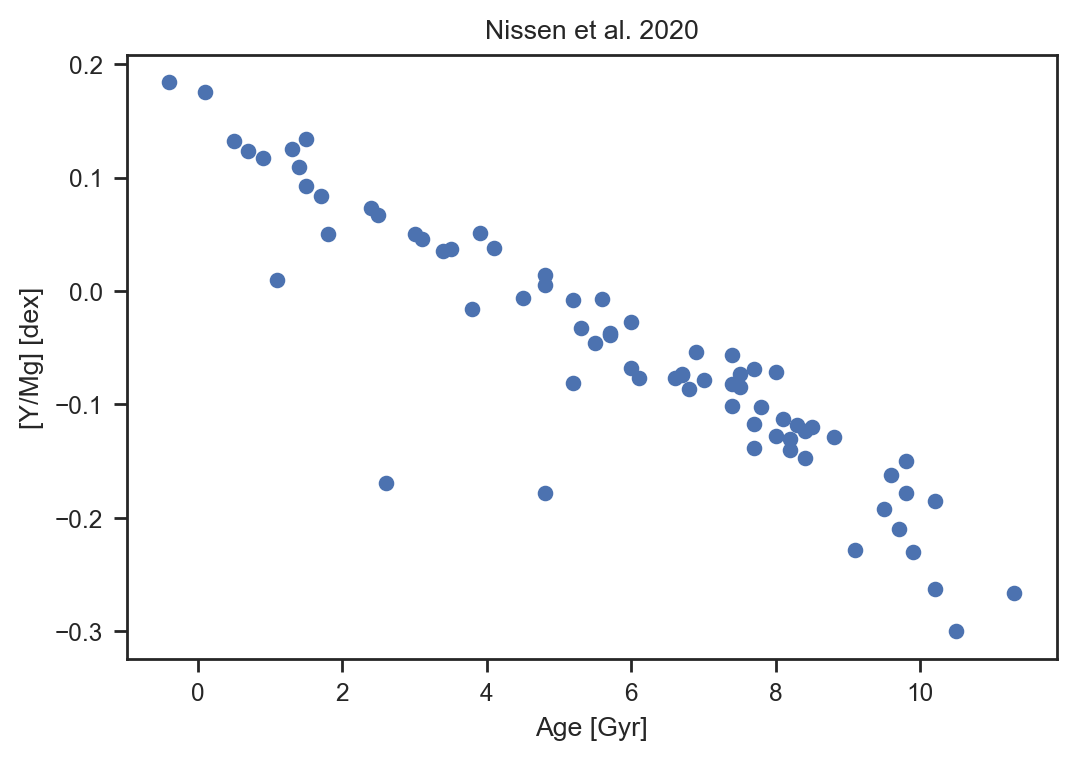

In [13]:
plt.scatter(nis['Age'], nis['ymg_ratio'])
plt.xlabel('Age [Gyr]')
plt.ylabel('[Y/Mg] [dex]')
plt.title('Nissen et al. 2020');

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X, y = nis[["ymg_ratio","Teff","logg-sp","[Fe/H]"]], nis.Age
model.fit(X, y)

#display adjusted R-squared
print(1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.9230786908531737


In [16]:
model = LinearRegression()
X, y = df[["bf18_[Y/Al]","p20_cks_steff","p20_cks_slogg","p20_cks_smet"]], df.cks_age
model.fit(X, y)

#display adjusted R-squared
print(1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.5139427720582905


In [17]:
X, y = df[["bf18_[Y/Al]","bf18_Teff","bf18_log(g)","bf18_[Fe/H]"]], df.bf18_Age
model.fit(X, y)

#display adjusted R-squared
print(1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.6118902288744827


In [18]:
X, y = df[["bf18_[Mg/Fe]",
           "bf18_[Y/Mg]",
           "bf18_[Y/Al]",
           "bf18_S/N",
           "bf18_Teff",
           "bf18_log(g)",
           "bf18_[Fe/H]"]], df.bf18_Age
model.fit(X, y)

#display adjusted R-squared
print(1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.6383336398820076


In [19]:
model.coef_

array([ 1.05684971e+01, -3.00481967e+00, -1.33907946e+00,  6.27173226e-04,
       -4.27723917e-03,  1.33833211e+00, -1.05034987e+00])

In [20]:
regression_cols = []

regression_cols.append("bf18_Teff")
regression_cols.append("bf18_log(g)")


for col in df.columns:
    if ("bf18_[" in col) & ("/H]" in col) & (col!="bf18_[M/H]"):
        regression_cols.append(col)


regression_cols = np.array(regression_cols)

In [21]:
X, y = df[regression_cols], df.bf18_Age
model.fit(X, y)

#display adjusted R-squared
print(1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.6624535580203492


In [22]:
for i in range(len(regression_cols)):
    print(regression_cols[i], model.coef_[i])

bf18_Teff -0.004563146756777753
bf18_log(g) 0.8641686375697459
bf18_[C/H] -1.0280753568573688
bf18_[N/H] -0.011715931592030404
bf18_[O/H] 2.3181997665004292
bf18_[Na/H] 2.259668074935238
bf18_[Mg/H] 12.69437201334598
bf18_[Al/H] 1.112922192282706
bf18_[Si/H] 6.221545579053888
bf18_[Ca/H] 0.5944288767187059
bf18_[Ti/H] -3.01531897275561
bf18_[V/H] 0.14010156288937609
bf18_[Cr/H] 5.483336266440945
bf18_[Mn/H] 0.9359679081924847
bf18_[Fe/H] -21.84582208977824
bf18_[Ni/H] -2.385047804190587
bf18_[Y/H] -4.385386418200684


Feature: 0, Score: -0.00456
Feature: 1, Score: 0.86417
Feature: 2, Score: -1.02808
Feature: 3, Score: -0.01172
Feature: 4, Score: 2.31820
Feature: 5, Score: 2.25967
Feature: 6, Score: 12.69437
Feature: 7, Score: 1.11292
Feature: 8, Score: 6.22155
Feature: 9, Score: 0.59443
Feature: 10, Score: -3.01532
Feature: 11, Score: 0.14010
Feature: 12, Score: 5.48334
Feature: 13, Score: 0.93597
Feature: 14, Score: -21.84582
Feature: 15, Score: -2.38505
Feature: 16, Score: -4.38539


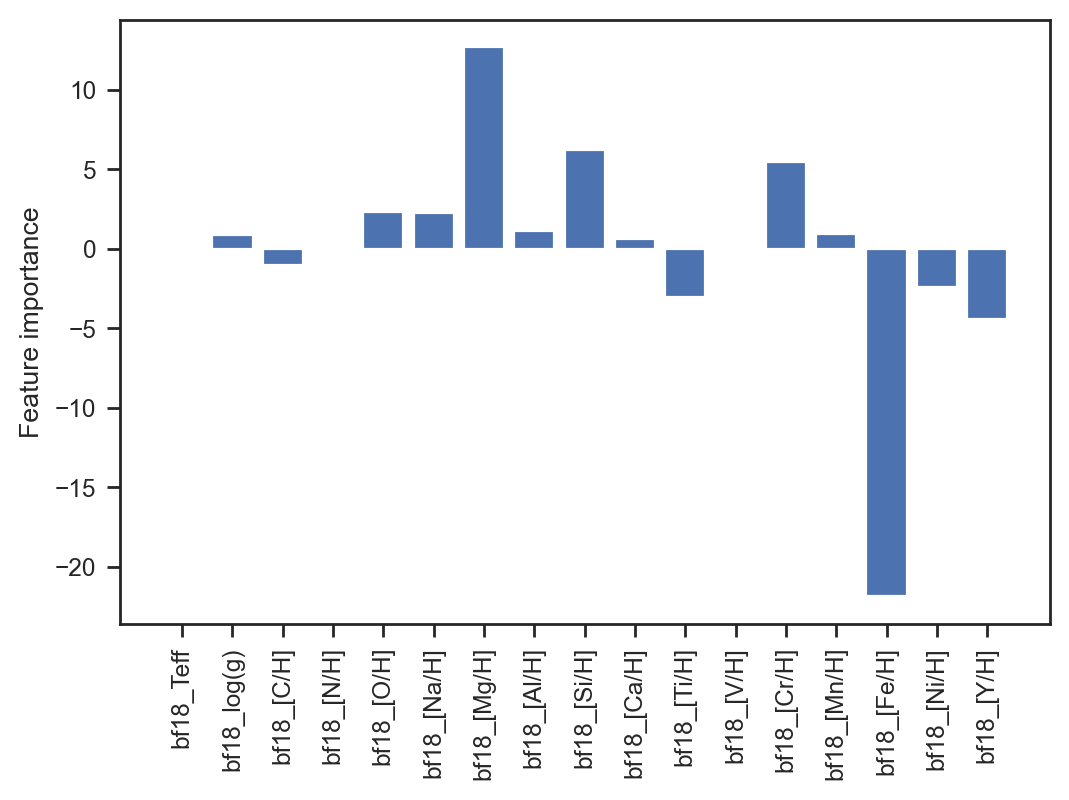

In [23]:
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(np.arange(len(importance)), regression_cols, rotation=90)
plt.ylabel("Feature importance")
plt.show()